# Практическое задание

## Интерполяция байеровского шаблона (demosaicing)

### О задании

В этом задании вам предстоит познакомится с простейшими инструментами считывания и обработки изображений в python, и с помощью них реализовать и протестировать 2 метода интерполяции байеровского шаблона. 

### Инструменты

Задание предполагает использование `python3`, не ниже версии `3.5`. 
Вам понадобится работать со следущими пакетами:

* [`numpy`](https://docs.scipy.org/doc/numpy/reference/index.html) - библиотека для работы с многомерными масивами и матрицами, содержащая большое кол-во высокоуровневых математических функций для операций с этими масивами.  


* [`skimage`](http://scikit-image.org/) - библиотека, содержащие большую коллекцию алгоритмов для обработки изображений;

* [`scipy`](https://www.scipy.org/) - библиотека, содержащая большой набор инструментов для математических и инженерных вычислений. Основная структура данных numpy массив.

* [`matplotlib`](https://matplotlib.org/) - библиотека для визуализации различных графиков, диаграмм, изображений и много другого.

In [1]:
#!pip install numpy scikit-image scipy matplotlib

### Общая информация

Фильтр Байера - это матрица цветных фильтров для фотосенсора фотоаппарта. Каждая ячейка матрицы представляет собой фильтр одного из цветов R, G или B. В классическом фильтре Байера применяются светофильтры трёх основных цветов в следующем порядке: <img src="bayer_pat.png" width="50">
Матрица является устройством, воспринимающим спроецированное на него изображение. Вследствие использования фильтров каждый фотоприемник воспринимает лишь 1/3 цветовой информации участка изображения, а 2/3 отсекается фильтром. Недостающие компоненты цвета рассчитываются процессором камеры на основании данных из соседних ячеек в результате интерполяции (demosaicing).
<img src="bayer.jpg" width="500">

Вам необходимо будет научиться востанавливать "полноцветное" изображение по байеровскому шаблону.

Вместе с заданием вам был выдан архив `data.zip`. В нем содержатся следущие данные:
* `raw/` - директория с  различными одноканальными изображениями, полученными с помощью фильтра Байера. Фильтр Байера который применялся, соответствует последовательности каналов(GRGB), показанной выше. В каждом пикселе изображения записан отклик фильтра соответсвующего цвета;
* `gt/` - директория с *ground truth* изображениями, каждому raw-изображению из предыдущей директории существует изображение из этой директории(с тем же именем) с истинными значениями RGB-канналов в каждом пикселе;
* `debug/` - изображения для самопроверки работы алгоритмов.

Выполненный нотбук сдается вместе с папкой `results`, где должны лежать результаты работы алгоритмов. Ниже будет описано подробнее. Все необходимо заархивировать в один zip файл.

### Практическая часть

In [2]:
import skimage.io
import numpy as np
import os
import matplotlib.pyplot as plt

In [3]:
GT_DIR = 'data/gt/'
RAW_DIR = 'data/raw/'

**1. (0.5 балла)**

Считайте raw и ground truth изображения `IMG0001.bmp`, выведите в какой тип данных они считались(список, массив, ...?), какой тип данных у пикселей изображения(float, int, ...?), размеры изображений.  Подумайте на тем как хранятся изображения в памяти.

Вам могут понадобиться:
* `skimage.io.imread(..)`

**Hint**: в jupyter-notebook если после ввода названия функции нажать сочетание клавиш `shift+tab` , выведется докстринг этой функции.

In [5]:
gt_image = skimage.io.imread('{}IMG0001.bmp'.format(GT_DIR)) # your code here
raw_image = skimage.io.imread('{}IMG0001.bmp'.format(RAW_DIR)) # your code here

print("Тип считанного изображения: {}".format(type(gt_image))) # your code here
print('Типы элементов матриц: {}'.format(gt_image.dtype)) # your code here
print("Размеры: {}".format(gt_image.shape)) # your code here

Тип считанного изображения: <class 'numpy.ndarray'>
Типы элементов матриц: uint8
Размеры: (512, 768, 3)


Теперь давайте посмотрим на считанные изображения. Для этого воспользуемся:
* `matplotlib.pyplot.subplots(...)` для создания фигуры, заданного размера, с нужным нам количеством окон
* `matplotlib.axes.Axes.imshow(...)` методом объекта `matplotlib.axes.Axes` для вывода изображения

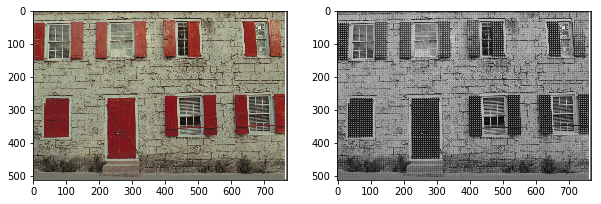

In [6]:
figure, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(gt_image)
axs[1].imshow(raw_image, cmap='gray')
plt.show()

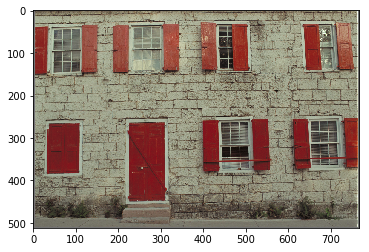

In [7]:
plt.imshow(gt_image)

**2. (0.5 балла)**

Перейдем непосредственного к интерепполяции байеровского шаблона.
Напишите вспомогательную функцию, которая для заданного размера raw-изображения создает маски для красных, зеленых и синих каналов байровского шаблона.

Вам могут понадобиться:
* `numpy.tile(...)`

In [6]:
def get_bayer_pattern_masks(h, w):
    """
    Get 3 masks for red, green, blue channels of bayer pattern size (h, w)

    :param h: int, height of bayer pattern
    :param w: int, width of bayer pattern
    :return: [numpy.ndarray((h, w)), numpy.ndarray((h, w)), numpy.ndarray((h, w))],
    list of 3 mask, size (h, w) for red, green, blue channels respectively
    """
    # your code here
    base_green = np.array([
        [1, 0],
        [0, 1]
    ])
    base_red = np.array([
        [0, 1],
        [0, 0]
    ])
    base_blue = np.array([
        [0, 0],
        [1, 0]
    ])
    def mask_by_base(h, w, base):
        mask = np.tile(base, reps=(h // 2, w // 2))
        if h % 2 != 0:
            mask = np.vstack((mask, mask[0, :]))
        if w % 2 != 0:
            mask = np.hstack((mask, np.array([mask[:, 0]]).T))
        return mask
    
    return mask_by_base(h, w, base_red), mask_by_base(h, w, base_green), mask_by_base(h, w, base_blue)

Проверьте правильность работы  функции с помощью простейшего теста.

In [7]:
# small test for self-examination
r, g, b = get_bayer_pattern_masks(3, 3) 
assert (r == np.array([
    [0, 1, 0], 
    [0, 0, 0], 
    [0, 1, 0]]
)).all()
assert (g == np.array([
    [1, 0, 1], 
    [0, 1, 0], 
    [1, 0, 1]]
)).all()
assert (b == np.array([
    [0, 0, 0], 
    [1, 0, 1], 
    [0, 0, 0]]
)).all()

**3. (0.5 балла)**

Посмотрим, что на самом деле хранится в raw-изображениях. Напишите функцию, которая создает цветное изображение из raw-изображения следущим образом: в каждый цветовой канал поместите только известные пиксели из raw-изображения, пиксели, в которых данный цвет неизвестен, поставьте 0. Сохраните данное изображение в файл `results/colored_raw_image.bmp` и посмотрите что получилось.

Вам может пригодиться:
* `np.where(...)`
* `skimage.io.imsave(...)`

In [8]:
def get_colored_raw_image(raw_image):
    """
    Create colored raw image.
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), colored raw image
    """
    # your code here
    red_mask, green_mask, blue_mask = get_bayer_pattern_masks(*raw_image.shape)
    colored_image = np.array([
        raw_image * red_mask,
        raw_image * green_mask,
        raw_image * blue_mask
    ]).reshape(*raw_image.shape, 3)
    
    
    return colored_image

/usr/local/lib/python3.6/site-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: results/colored_raw_image.bmp is a low contrast image
  warn('%s is a low contrast image' % fname)
/usr/local/lib/python3.6/site-packages/skimage/util/dtype.py:126: UserWarning: Possible sign loss when converting negative image of type int64 to positive image of type uint8.
  .format(dtypeobj_in, dtypeobj_out))
/usr/local/lib/python3.6/site-packages/skimage/util/dtype.py:179: UserWarning: Downcasting int64 to uint8 without scaling because max value 255 fits in uint8
  "value {} fits in {}".format(a.dtype, dtype, a.max(), dtype))


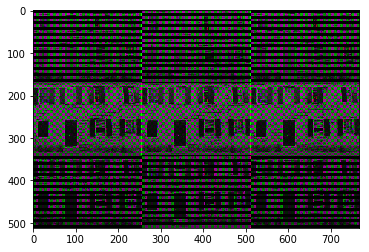

In [9]:
colored_raw_image = get_colored_raw_image(raw_image)
os.makedirs('results/', exist_ok=True)

# your code here
skimage.io.imsave(fname='results/colored_raw_image.bmp', arr=colored_raw_image)
plt.imshow(colored_raw_image)

In [10]:
colored_raw_image[:, :, 0].shape

(512, 768)

**4. (3 балла)**

Напишите алгоритм билинейной интерполяции байеровского шаблона. В этом алгоритме **неизвестные** значения цветовых компонент вычисляются следущим образом:
* рассматривается окно 3x3 с центром в данном пикселе
* значение цветовой компоненты(r, g, или b) в данном пикселе вычисляется как среднее **заданных** значений данной цветовой компоненты пикселей в этом окне

Например, если, мы хотим интерполировать значение зеленой компоненты цвета в пикселе отмеченном '$+$' на рисунке, нам необходимо усреднить значение 4-х зеленых конпонент в 3x3 окрестности, отмеченных '$\cdot$' 

<img src="example.png" width="130">

В данном задание разрешается обходить матрицу и попиксельно вычислять цветовые компоненты. На будущих занятих вы познакомитесь с понятием "cвертка", и узнаете как на питоне можно было бы избежать обхода матрицы.

Вам может пригодиться:
* `numpy.stack(...)`
* `numpy.rint(...)`

**Замечания:** 
* Поведение на границе, где окно 3x3 неполное, выберите на свое усмотрение, при подсчете метрик оно учитываться не будет.
* Выполнение алгоритма на одном изображении не должно занимать более 20 секунд.
* Будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа и округлением, рекомендуется в самом начале вычислений преобразовывать изображения в тип `float64`, а после окончания округлять значения до целых с помощью `numpy.rint(...)` и преобразовывать тип обратно в `uint8`.

In [11]:
def bilinear_interpolation(raw_image):
    """
    Perform bilinear interpolation demosaicing algorithm on raw image
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), interpolated image
    """
    h, w = raw_image.shape
    image = np.zeros((h, w, 3), dtype=np.float64)
    
    # your code here
    masks = get_bayer_pattern_masks(*raw_image.shape)
    for color in range(3):
        for i in range(h):
            for j in range(w):
                if masks[color][i, j] == 1:
                    image[i, j, color] = raw_image[i][j]
                else:
                    window = raw_image[i - 1 : i + 2, j - 1 : j + 2]
                    mask = masks[color][i - 1 : i + 2, j - 1 : j + 2]
                    number = np.sum(mask)
                    image[i, j, color] = np.sum(window * mask) / number

    return np.rint(image).astype(np.uint8)

Проверьте правильность работы функции с помощью простейшего теста. 

In [12]:
# small test for self-examination
raw_image = skimage.io.imread('data/raw/IMG0001.bmp')
image_true = skimage.io.imread('data/debug/IMG0001_bilinear.bmp')
diff = np.abs(bilinear_interpolation(raw_image) - image_true)[1:-1, 1:-1].sum()
assert diff == 0

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


Вычислите билинейную интерполяцию байеровского шаблона для всех изображений из директории `raw/` и сохраните в директорию `results/bilinear/`. Посмотрите на результаты интерполяции, сделайте выводы о плюсах и минусах этого алгоритма.

In [13]:
OUTPUT_DIR = 'results/bilinear'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# your code here
images = skimage.io.ImageCollection('data/raw/*')
for image, name in zip(images, images.files):
    skimage.io.imsave('{}/{}'.format(OUTPUT_DIR, name.replace('data/raw/', '')), 
                      arr=bilinear_interpolation(image))

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


**Выводы:**

Билинейная интерполяция неплохо справляется с задачей восстановления цвета. У нее есть проблемы при контрастных переходах цвета и с элементами типа частых цветных полосок, потому что простое усреднение не может это уловить.

**5. (1 балл)**

Для численной оценки работы алгоритма билинейной интерполяции реализуйте следущие метрики качества:

* Mean squared error $mse(pred\_image, gt\_image) = \frac{1}{3 * h * w} \sum_{i=1}^{h} \sum_{j=1}^{w} \sum_{c=1}^{3} (gt\_image[i, j, c] - pred\_image[i,j,c])^2$ 

* Peak signal-to-noise ratio $psnr(pred\_image, gt\_image) = 10 \log_{10}{(\frac{max(gt\_image)^2}{mse(pred\_image, gt\_image)} )}$

где $gt\_image$ - истинное изображение, $pred\_image$ - предсказанное.

Вычислите среднее значение этих метрик для всего датасета. При подсчете метрик не учитывайте, границу изображения, длиной в 2 пикселя.

Вам может понадобиться:
* `numpy.ndarray.mean(...)`
* `numpy.ndarray.max(...)`
* `numpy.log10(...)`

**Замечание:** Будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа, рекомендуется в самом начале вычислений преобразовать изображение в тип `float64`.

In [14]:
def mse_score(pred_image, gt_image):
    """
    Compute mean squared error
    :param pred_image: numpy.ndarray((h, w, 3), dtype=np.uint8), predicted image
    :param gt_image: numpy.ndarray((h, w, 3), dtype=np.uint8), ground truth image
    :return:
    """

    pred_image = pred_image.astype(np.float64)
    gt_image = gt_image.astype(np.float64)
    
    # your code here
    return np.mean((gt_image - pred_image) ** 2)


def psnr_score(pred_image, gt_image):
    """
    Compute peak signal-to-noise ratio
    :param pred_image: numpy.ndarray((h, w, 3), dtype=np.uint8), predicted image
    :param gt_image: numpy.ndarray((h, w, 3), dtype=np.uint8), ground truth image
    :return:
    """
    pred_image = pred_image.astype(np.float64)
    gt_image = gt_image.astype(np.float64)
    
    # your code here
    
    return 10 * np.log10(np.max(gt_image) ** 2 / mse_score(pred_image, gt_image))

In [15]:
# your code here
gt_images = skimage.io.ImageCollection('data/gt/*')
pred_images = skimage.io.ImageCollection('results/bilinear/*')

mse_sum = psnr_sum = number = 0
for gt_image, pred_image in zip(gt_images, pred_images):
    number += 1
    mse_sum += mse_score(pred_image[1: -1], gt_image[1: -1])
    psnr_sum += psnr_score(pred_image[1: -1], gt_image[1: -1])
    
print('Avg MSE: {}'.format(round(mse_sum / number, 5)))
print('Avg PSNR: {}'.format(round(psnr_sum / number, 5)))

Avg MSE: 85.99069
Avg PSNR: 29.44853


**6. (3.5 балла)**

Теперь реализуем более сложную версию линейной интерполяции баеровского шаблона. Прочитайте статью, выданную вам совместно с ноутбуком, и реализуйте предложенный в ней алгоритм. Вычислите интерполяцию для всех изображений и сохраните в директорию `results/improved/`. Посчитайте средние значения метрик качества. 

**Замечания по поводу алгоритма:**
* в работе указанные фильтры неотнормированны к единице(сумма коэффициентов не равняется 1), чтобы сохранить масштаб значений, коэффициенты необходимо отнормировать на сумму значений в данном фильтре;
* в результате указанных в работе фильтров могут получаться значения большие 255 и меньшие 0, вам необходимо отрезать слишком большие и слишком маленькие значения по крайним значениям(`numpy.clip`);
* веса фильтров были выписаны в массивы за вас для избежания лишних ошибок.

**Замечание:** Как никогда будьте аккуратны с вычислениями, raw-изображние хранит `uint8` значения. Для избежания ошибок, связанных с переполнением типа и округлением, рекомендуется в самом начале вычислений преобразовывать изображения в тип `float64`, а после окончания округлять значения до целых с помощью `numpy.rint(...)` и преобразовывать тип обратно в `uint8`.

In [16]:
weigths_0 = (1 / 8) * np.array([
    [ 0,  0, 1/2,  0,  0],
    [ 0, -1,   0, -1,  0],
    [-1,  4,   5,  4, -1],
    [ 0, -1,   0, -1,  0],
    [ 0,  0, 1/2,  0,  0]
])

weigths_1 = (1 / 8) * np.array([
    [  0,  0,  -1,  0,   0],
    [  0, -1,   4, -1,   0],
    [1/2,  0,   5,  0, 1/2],
    [  0, -1,   4, -1,   0],
    [  0,  0,  -1,  0,   0]
])

weigths_2 = (1 / 8) * np.array([
    [   0,  0, -3/2,  0,    0],
    [   0,  2,    0,  2,    0],
    [-3/2,  0,    6,  0, -3/2],
    [   0,  2,    0,  2,    0],
    [   0,  0, -3/2,  0,    0]
])

weigths_3 = (1 / 8) * np.array([
    [ 0,  0, -1,  0,  0],
    [ 0,  0,  2,  0,  0],
    [-1,  2,  4,  2, -1],
    [ 0,  0,  2,  0,  0],
    [ 0,  0, -1,  0,  0]
])

In [17]:
def improved_linear_interpolation(raw_image):
    """
    Improved linear interpolation demosaicing algorithm on raw image
    
    :param raw_image: numpy.ndarray((h, w), dtype=np.uint8), raw image created with bayer pattern
    :return: numpy.ndarray((h, w, 3), dtype=np.uint8), interpolated image
    """

    h, w = raw_image.shape
    image = np.zeros((h, w, 3), np.float64)
    
    # your code here
    masks = get_bayer_pattern_masks(*raw_image.shape)
    
    def get_gradient_correction(i, j, color):
        if i < 2 or i > h - 3 or j < 2 or j > w - 3:
            return 0
        if masks[color][i, j]:
            return raw_image[i, j]
        weigths = None
        if color == 1:
            weigths = weigths_3
        elif (color == 0 and masks[1][i, j] == 1 and masks[0][i, j + 1] == 1) or \
        (color == 2 and masks[1][i, j] == 1 and masks[2][i, j + 1] == 1):
            weigths = weigths_0
        elif (color == 0 and masks[1][i, j] == 1 and masks[0][i + 1, j] == 1) or \
        (color == 2 and masks[1][i, j] == 1 and masks[2][i + 1, j] == 1):
            weigths = weigths_1
        elif (color == 0 and masks[2][i, j] == 1 and masks[0][i + 1, j + 1] == 1) or \
        (color == 2 and masks[0][i, j] == 1 and masks[2][i + 1, j + 1] == 1):
            weigths = weigths_2
        result = np.sum(raw_image[i - 2: i + 3, j - 2: j + 3] * weigths)
        if result < 0:
            return 0
        if result > 255:
            return 255
        return result
    
    for color in range(3):
        for i in range(h):
            for j in range(w):
                image[i, j, color] += get_gradient_correction(i, j, color)

    return np.rint(image).astype(np.uint8)

Проверьте правильность работы функции с помощью прmостейшего теста. 

In [18]:
# small test for self-examination
raw_image = skimage.io.imread('data/raw/IMG0001.bmp')
image_true = skimage.io.imread('data/debug/IMG0001_improved.bmp')
diff = np.abs(improved_linear_interpolation(raw_image) - image_true)[2:-2, 2:-2].sum()
assert diff == 0

In [19]:
OUTPUT_DIR2 = 'results/improved/'
os.makedirs(OUTPUT_DIR2, exist_ok=True)

# your code here
images = skimage.io.ImageCollection('data/raw/*')
for image, name in zip(images, images.files):
    skimage.io.imsave('{}/{}'.format(OUTPUT_DIR2, name.replace('data/raw/', '')), 
                      arr=improved_linear_interpolation(image))

In [20]:
gt_images = skimage.io.ImageCollection('data/gt/*')
pred_images_improved = skimage.io.ImageCollection('results/improved/*')

mse_sum_improved = psnr_sum_improved = number = 0
for gt_image, pred_image in zip(gt_images, pred_images_improved):
    number += 1
    mse_sum_improved += mse_score(pred_image[2: -2], gt_image[2: -2])
    psnr_sum_improved += psnr_score(pred_image[2: -2], gt_image[2: -2])
    
print('Avg MSE: {}'.format(round(mse_sum_improved / number, 5)))
print('Avg PSNR: {}'.format(round(psnr_sum_improved / number, 5)))

Avg MSE: 119.71981
Avg PSNR: 27.49817


**7. (1 балл)**

Проведите сравненение двух алгоритмов. Сравните два алгоритма по метрикам качества. А также выберите сложные моменты("окна" изображениях) для интерполяции и визуализируйте эти "окна". Сравнивайте работу первого алгоритма, второго алгоритма и ground truth. Найдите 3-4 таких "окна". Сделайте выводы.

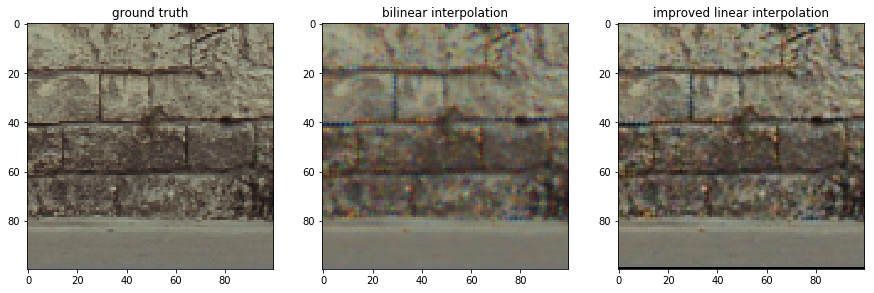

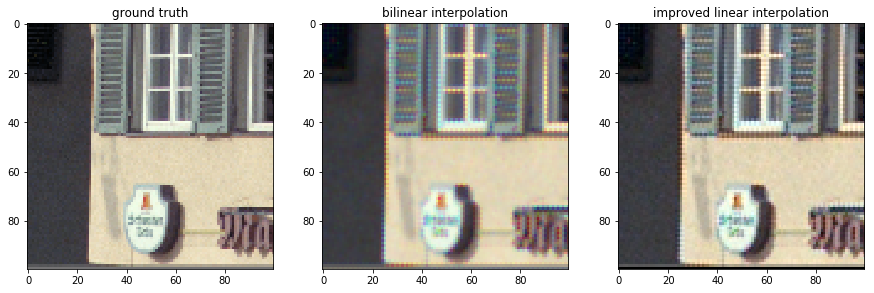

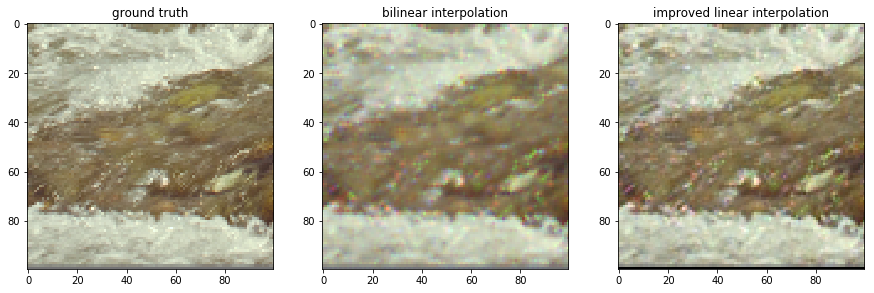

In [21]:
# your code here
windows = 0
for gt_image, pred_image, pred_image_improved in zip(gt_images, pred_images, pred_images_improved):
    mse_pred = mse_score(pred_image, gt_image)
    if mse_pred < 180.:
        continue
    h, w, _ = gt_image.shape
    diff = np.abs(gt_image - pred_image).sum(axis=2)
    maxs = np.asarray(np.where(diff == diff.max()))
    
    i, j = maxs.T[0]
    for x, y in maxs.T:
        if x > 50 and x < h - 50 and y > 50 and y < w - 50:
            i, j = x, y
    
    figure, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(gt_image[i - 50: i + 50, j - 50: j + 50])
    axs[0].set_title('ground truth')
    axs[1].imshow(pred_image[i - 50: i + 50, j - 50: j + 50])
    axs[1].set_title('bilinear interpolation')
    axs[2].imshow(pred_image_improved[i - 50: i + 50, j - 50: j + 50])
    axs[2].set_title('improved linear interpolation')
    plt.show()
    
    windows += 1
    if windows >= 4:
        break

**Выводы: **

Улучшенный метод лучше справляется с резкими градиентными сменами цвета, но все еще имеет проблемы с часто меняющимися цветами.

Также он показывает прирост метрики PSNR.